In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score
from math import sqrt

In [2]:
df = pd.read_csv('champagne.csv',parse_dates=True,index_col=0,header=0)
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['Sales'])
df.columns=['Value']
     

In [3]:
df

,Value
Month,
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946
...,...
1972-05,4618
1972-06,5312
1972-07,4298


In [4]:
df.head()

,Value
Month,
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946


In [5]:
df.tail()

,Value
Month,
1972-05,4618
1972-06,5312
1972-07,4298
1972-08,1413
1972-09,5877


In [6]:
df.describe()

,Value
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105 entries, 1964-01 to 1972-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Value   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6+ KB


In [8]:
df.isnull().sum()

Value    0
dtype: int64

In [9]:
#VISUALIZING THE DATA

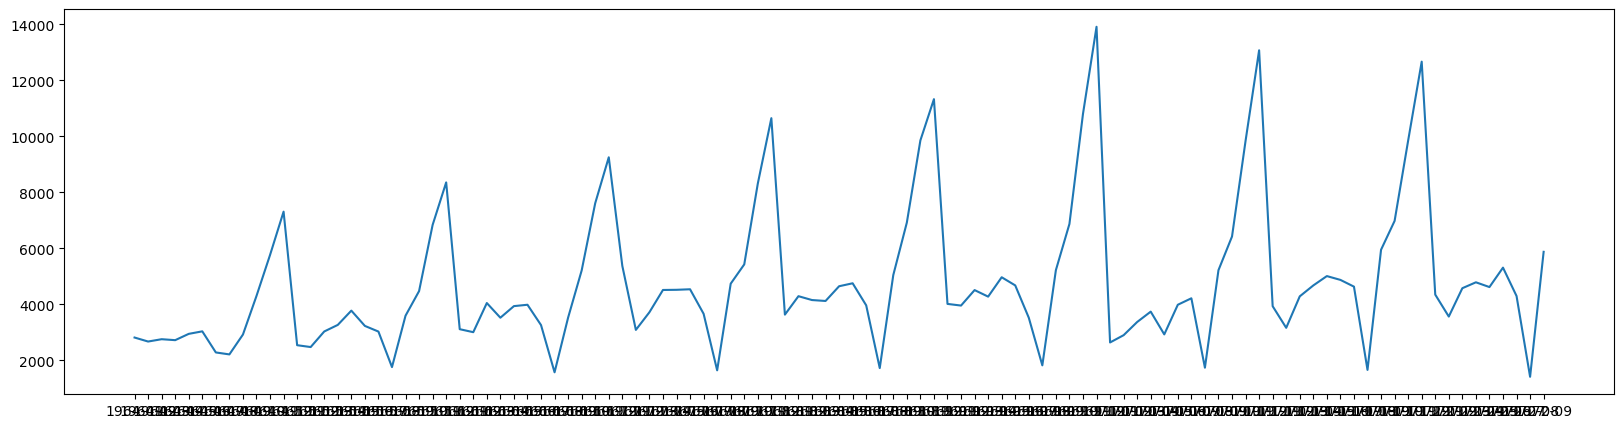

In [10]:
plt.figure(figsize=(20,5))
plt.plot(df)

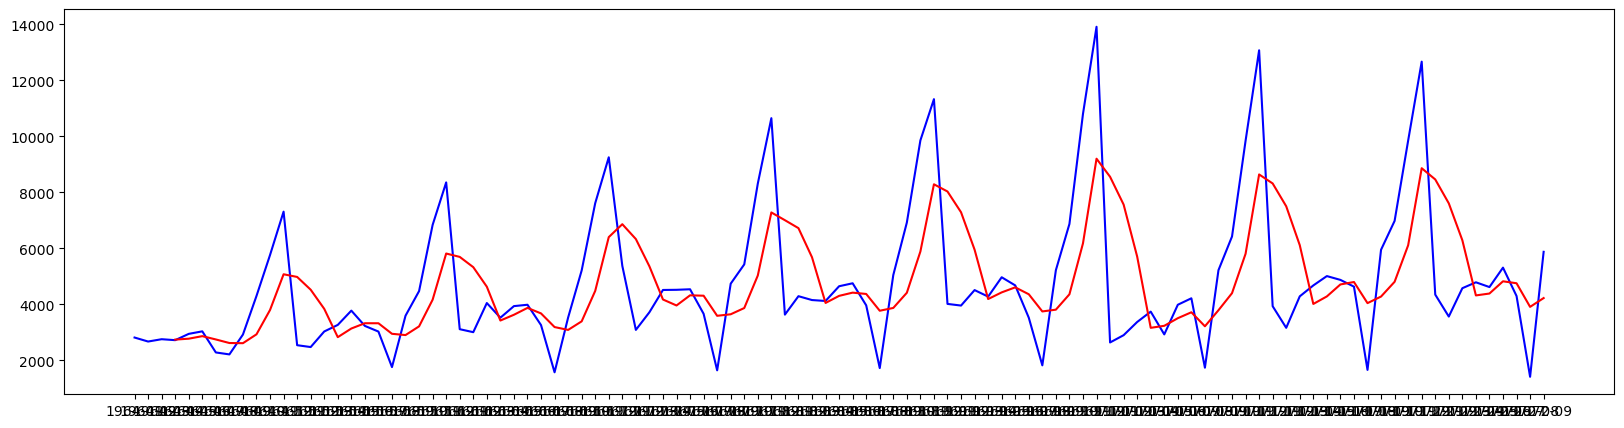

In [11]:
plt.figure(figsize=(20,5))
four_months_moving_average=df.rolling(window=4).mean()
plt.plot(df,color='blue')
plt.plot(four_months_moving_average,color='red')
plt.show()

<Axes: xlabel='Value', ylabel='Density'>

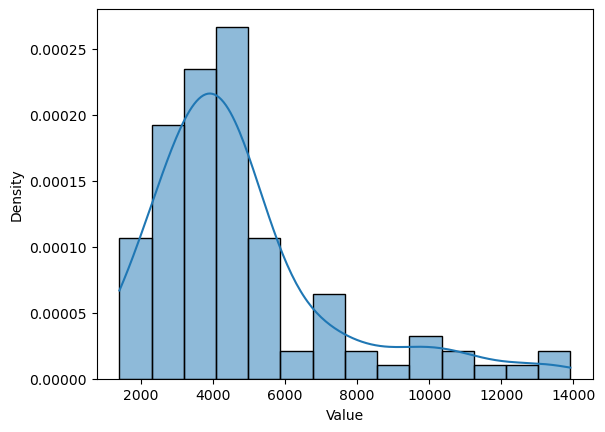

In [12]:
sns.histplot(df['Value'],kde=True,stat='density')

<Figure size 640x480 with 0 Axes>

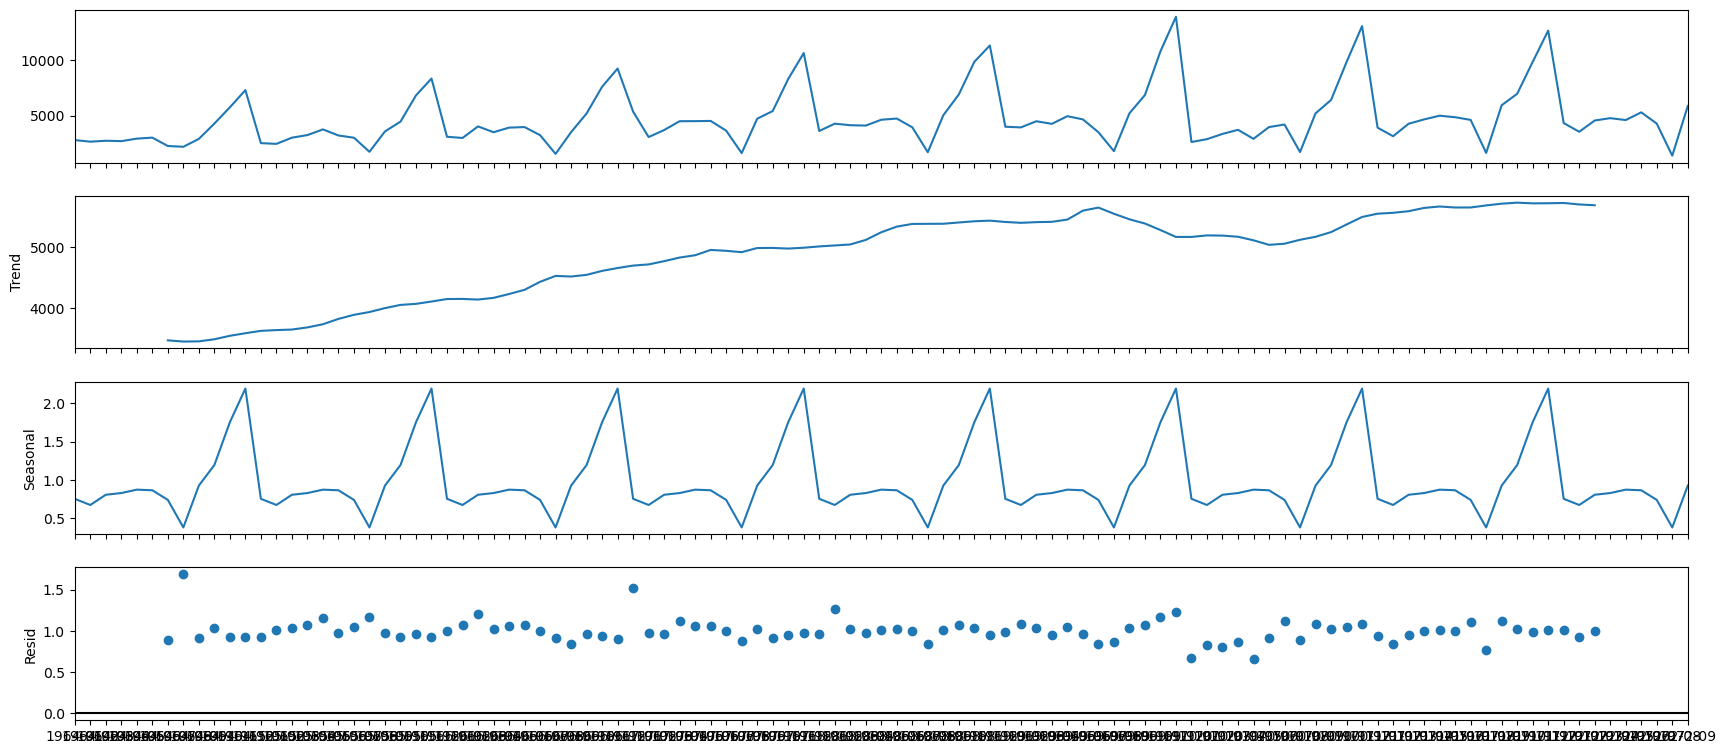

In [13]:
seasonal=seasonal_decompose(df,model='multiplicative',period=12)
fig=plt.figure()
fig=seasonal.plot()
fig.set_size_inches(20,8)

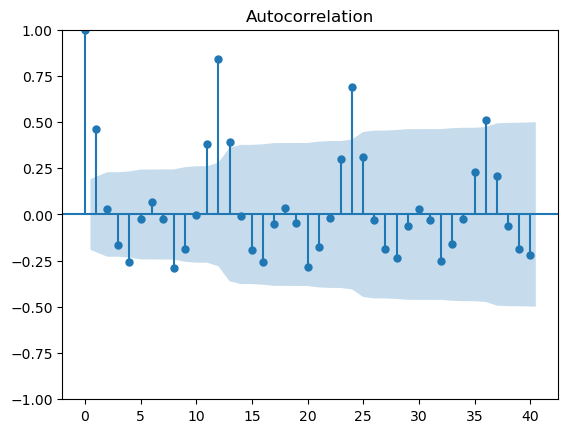

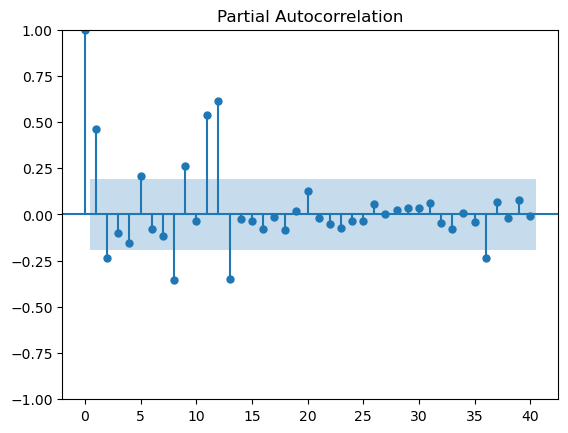

In [14]:
acf=plot_acf(df['Value'],lags=40)
pacf=plot_pacf(df['Value'],lags=40)

In [15]:
# ADF TEST(augumented dickey fuller test)

In [16]:
from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    
    #Pass in a time series, returns ADF report

    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")
     

In [17]:
adf_check(df)

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.833593056327623
p-value : 0.363915771660245
Number of Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



In [18]:
#BUILDING ARIMA MODEL

#MATHEMATICAL EQUATION
#y't = C + ϕ1y't–1 +⋅⋅⋅ ϕp y't–p + θ1ϵ't–1 +⋅⋅⋅+ θqϵ't–q + ϵt
#1.MAKING THE DATA STATIONARY BY DIFFERENCING
#2.FITTING THE AUTO REGRESSIVE MODEL
#3.FITTING THE MOVING AVERAGE MODEL ON RESIDUALS

In [19]:
df1= pd.DataFrame(np.log(df.Value).diff().diff(1))
adf_check(df1.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.297755491734625
p-value : 4.096129651363341e-13
Number of Lags Used : 13
Number of Observations Used : 89
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Month'>

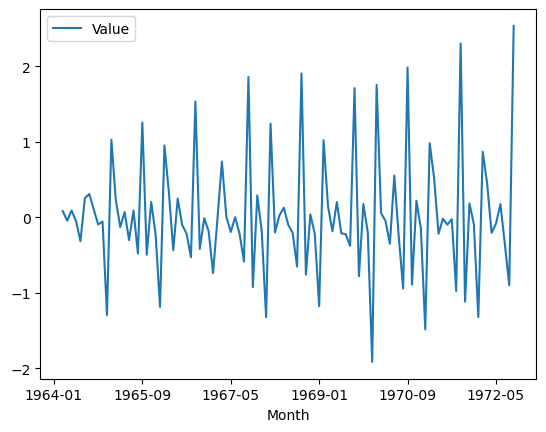

In [20]:
df1.plot()

In [21]:
#AR MODEL

In [22]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]
     


In [23]:


for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df1.Value))
  

The RMSE is : 0.8817373727366954 , Value of p :  1
The RMSE is : 0.8081460689033355 , Value of p :  2
The RMSE is : 0.8084266278173564 , Value of p :  3
The RMSE is : 0.7199072701505708 , Value of p :  4
The RMSE is : 0.6144555090514715 , Value of p :  5
The RMSE is : 0.5342142762669925 , Value of p :  6
The RMSE is : 0.5134107558350123 , Value of p :  7
The RMSE is : 0.509566220590384 , Value of p :  8
The RMSE is : 0.5066721574010422 , Value of p :  9
The RMSE is : 0.5230290333627997 , Value of p :  10
The RMSE is : 0.19958800444422897 , Value of p :  11
The RMSE is : 0.1989474489028657 , Value of p :  12
The RMSE is : 0.21564409916061106 , Value of p :  13
The RMSE is : 0.2137066072482386 , Value of p :  14
The RMSE is : 0.21689976661344781 , Value of p :  15
The RMSE is : 0.2181940097739042 , Value of p :  16
The RMSE is : 0.2252778595940304 , Value of p :  17
The RMSE is : 0.2386490459156972 , Value of p :  18
The RMSE is : 0.2369395607174829 , Value of p :  19
The RMSE is : 0.241

C:\Users\user\AppData\Local\Temp\ipykernel_7696\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_7696\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_7696\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [24]:
[df_train,df_test,theta,intercept,RMSE] = AR(12,pd.DataFrame(df1.Value))

The RMSE is : 0.1989474489028657 , Value of p :  12


C:\Users\user\AppData\Local\Temp\ipykernel_7696\2532613571.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


<Axes: xlabel='Month'>

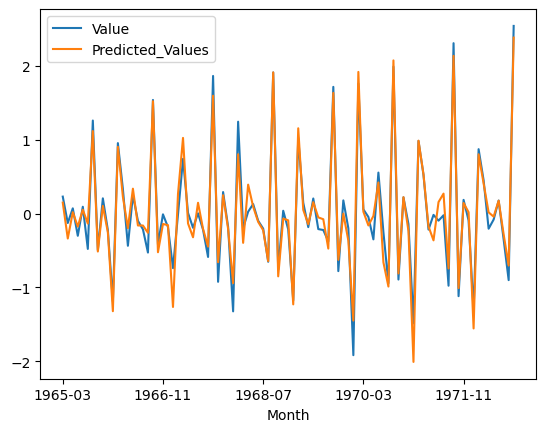

In [25]:
df2 = pd.concat([df_train,df_test])
df2[['Value','Predicted_Values']].plot()
     

In [26]:
res = pd.DataFrame()
res['Residuals'] = df2.Value - df2.Predicted_Values
     

In [27]:
res

,Residuals
Month,
1965-03,0.081329
1965-04,0.209782
1965-05,0.052072
1965-06,-0.124580
1965-07,0.039446
...,...
1972-05,-0.039187
1972-06,0.002252
1972-07,-0.068938


<Axes: ylabel='Density'>

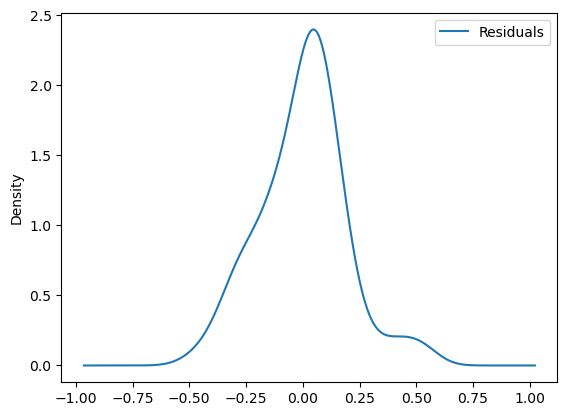

In [28]:
res.plot(kind='kde')

In [29]:
#MA MODEL

In [30]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.17260166967272186 , Value of q :  1
The RMSE is : 0.1795405924158958 , Value of q :  2
The RMSE is : 0.17837460836890878 , Value of q :  3
The RMSE is : 0.18693287797885488 , Value of q :  4
The RMSE is : 0.18406025566438342 , Value of q :  5
The RMSE is : 0.18178992510878025 , Value of q :  6
The RMSE is : 0.1701791232518365 , Value of q :  7
The RMSE is : 0.1729774800137767 , Value of q :  8
The RMSE is : 0.18166642716629386 , Value of q :  9
The RMSE is : 0.16013260144087235 , Value of q :  10
The RMSE is : 0.1678243937892158 , Value of q :  11
The RMSE is : 0.17854173081686364 , Value of q :  12
The RMSE is : 0.196462897326016 , Value of q :  13
The RMSE is : 0.1969608318303891 , Value of q :  14


C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.19179504115907162 , Value of q :  15
The RMSE is : 0.18967499524028072 , Value of q :  16
The RMSE is : 0.18853829757410492 , Value of q :  17
The RMSE is : 0.187461395712362 , Value of q :  18


C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

The RMSE is : 0.22054285950557095 , Value of q :  19
The RMSE is : 0.22618228824929373 , Value of q :  20


C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


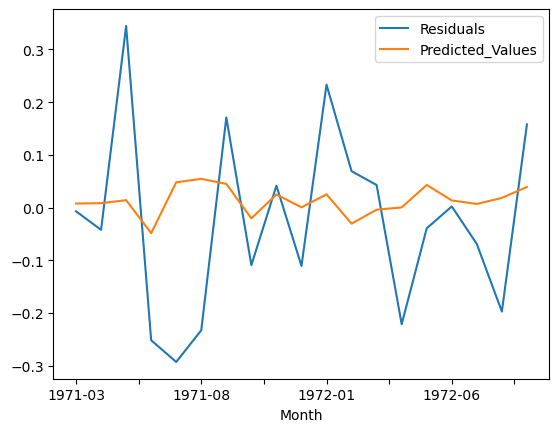

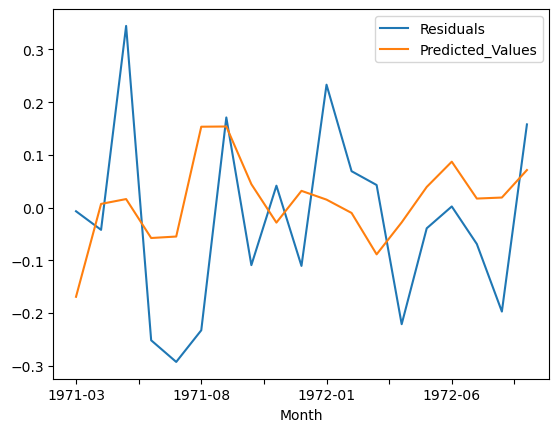

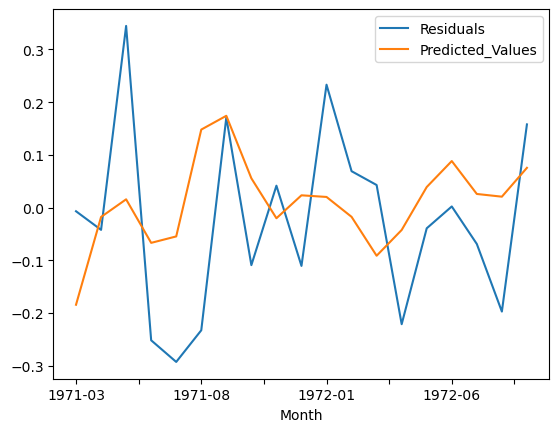

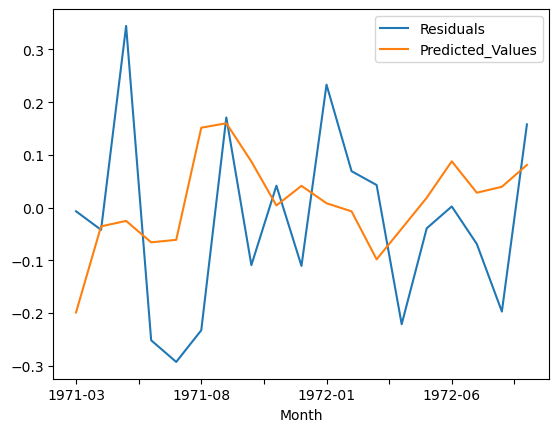

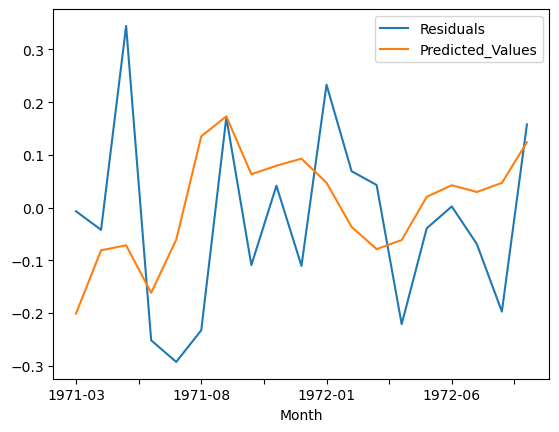

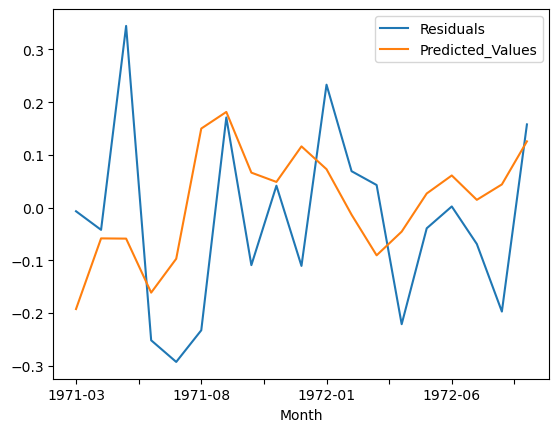

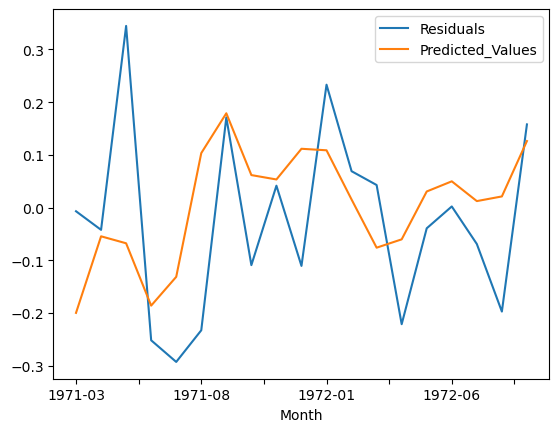

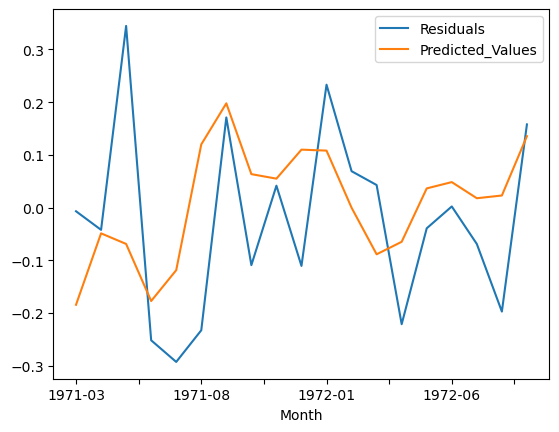

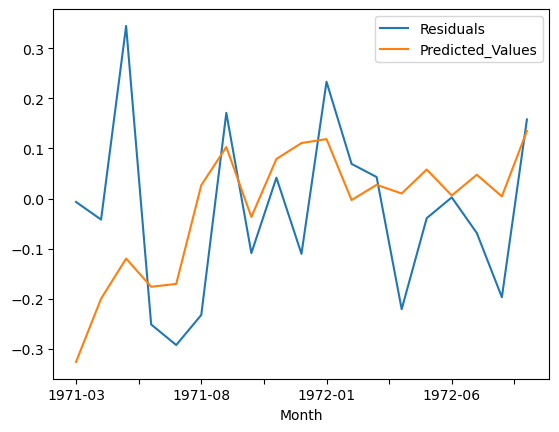

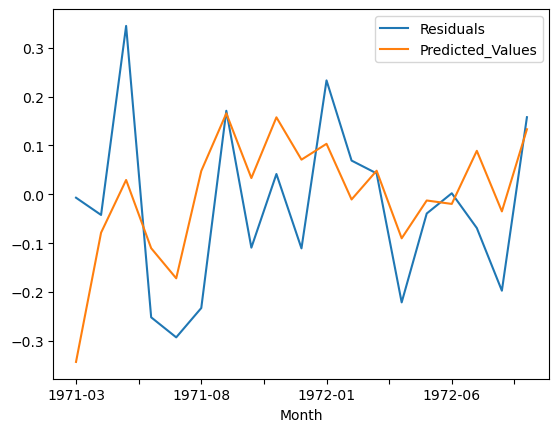

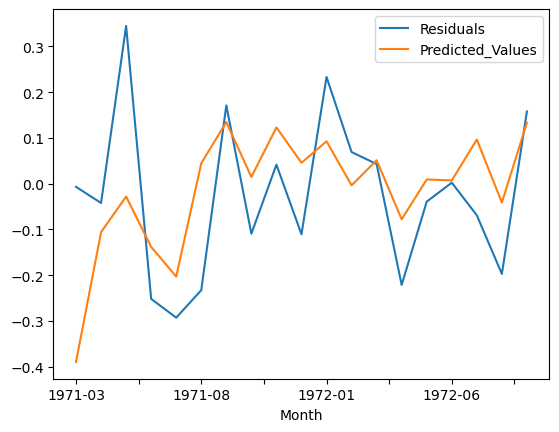

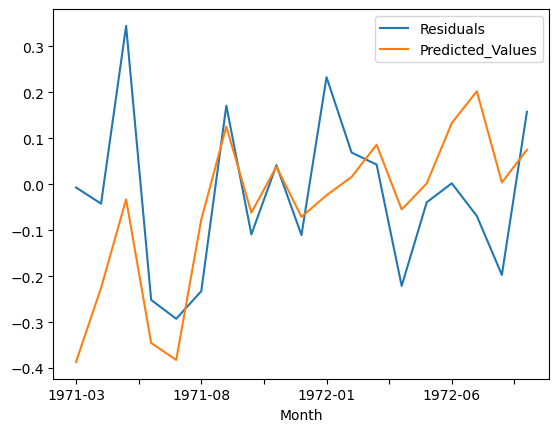

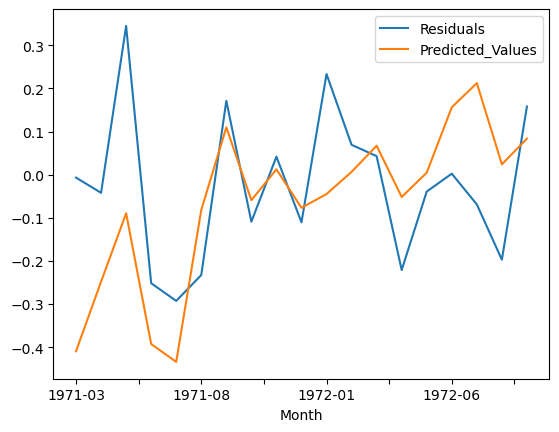

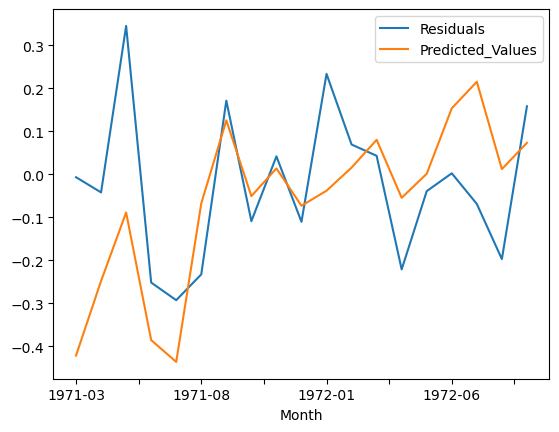

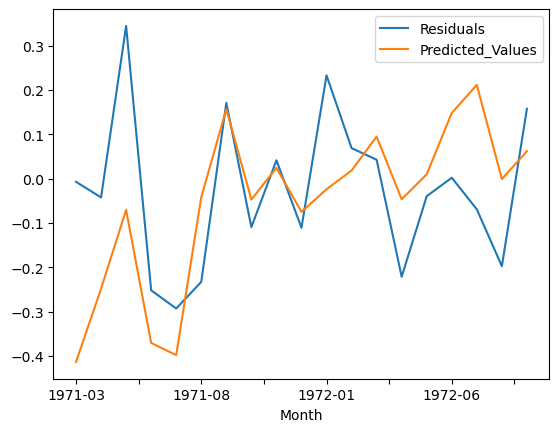

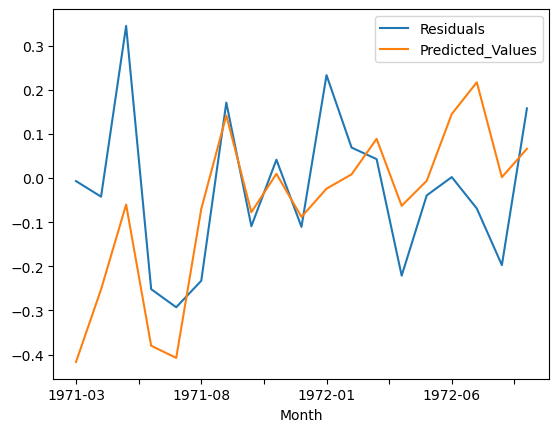

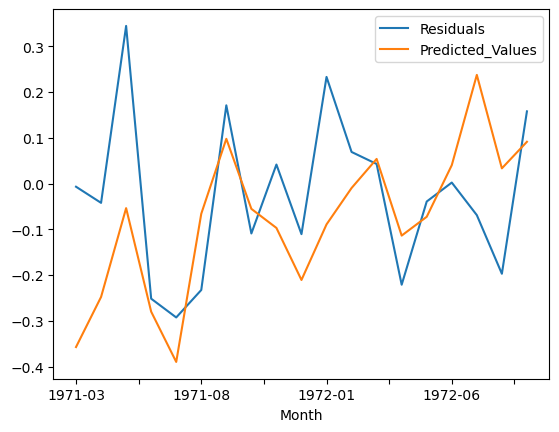

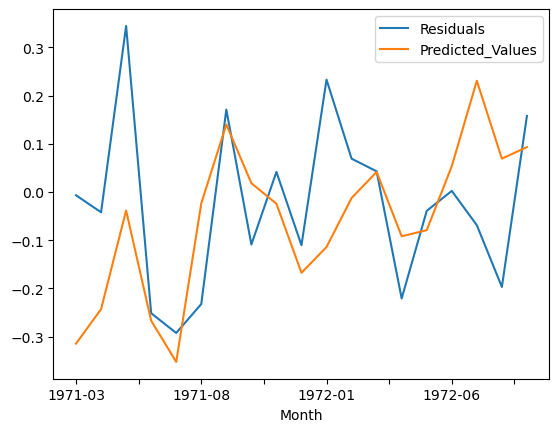

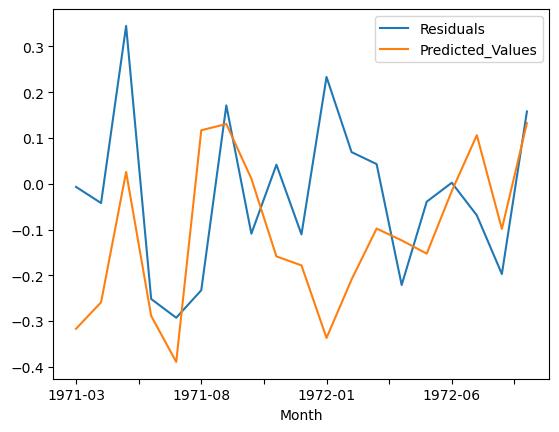

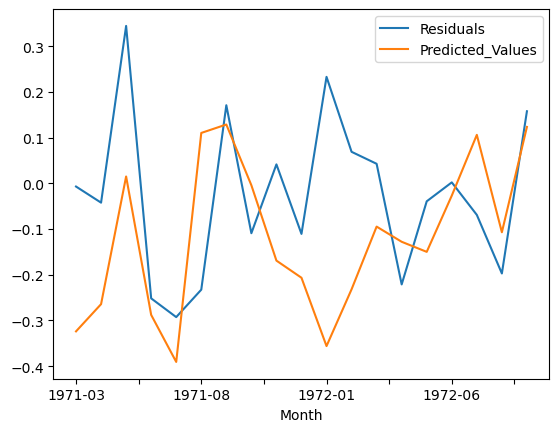

In [31]:


for i in range(1,21):
    
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
                                                                


The RMSE is : 0.17854173081686364 , Value of q :  12
[[-0.223285  ]
 [-0.47499917]
 [-0.23402429]
 [-0.21216563]
 [-0.30581117]
 [-0.21798711]
 [-0.32975739]
 [-0.13740765]
 [-0.34504898]
 [-0.0136908 ]
 [-0.2211732 ]
 [-0.36845935]]
[-0.01146327]


C:\Users\user\AppData\Local\Temp\ipykernel_7696\1990097179.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


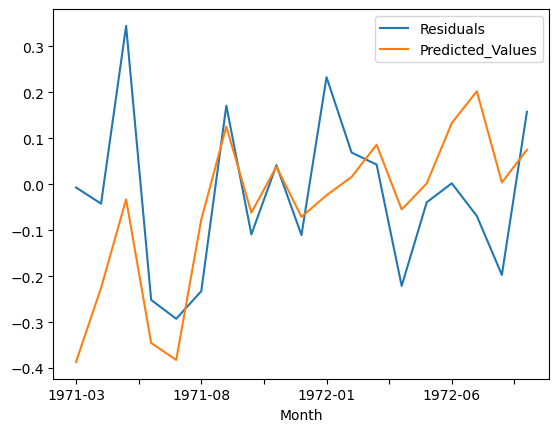

In [32]:
[res_train,res_test,theta,intercept,RMSE] = MA(12,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)
     

In [33]:
res1 = pd.concat([res_train,res_test])

In [34]:
res1

,Residuals,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
Month,,,,,,,,,,,,,,
1966-03,0.105798,0.050262,0.132937,0.030421,0.101954,0.017604,0.142458,-0.342504,0.039446,-0.124580,0.052072,0.209782,0.081329,-0.077587
1966-04,-0.237611,0.105798,0.050262,0.132937,0.030421,0.101954,0.017604,0.142458,-0.342504,0.039446,-0.124580,0.052072,0.209782,-0.232173
1966-05,-0.086317,-0.237611,0.105798,0.050262,0.132937,0.030421,0.101954,0.017604,0.142458,-0.342504,0.039446,-0.124580,0.052072,0.020471
1966-06,0.062645,-0.086317,-0.237611,0.105798,0.050262,0.132937,0.030421,0.101954,0.017604,0.142458,-0.342504,0.039446,-0.124580,-0.005360
1966-07,-0.051446,0.062645,-0.086317,-0.237611,0.105798,0.050262,0.132937,0.030421,0.101954,0.017604,0.142458,-0.342504,0.039446,0.033514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972-05,-0.039187,-0.221085,0.042909,0.069144,0.233237,-0.110525,0.041644,-0.109044,0.171074,-0.232607,-0.292654,-0.251630,0.344723,0.001932
1972-06,0.002252,-0.039187,-0.221085,0.042909,0.069144,0.233237,-0.110525,0.041644,-0.109044,0.171074,-0.232607,-0.292654,-0.251630,0.133206
1972-07,-0.068938,0.002252,-0.039187,-0.221085,0.042909,0.069144,0.233237,-0.110525,0.041644,-0.109044,0.171074,-0.232607,-0.292654,0.202580


In [35]:
df2.Predicted_Values += res1.Predicted_Values
     


<Axes: xlabel='Month'>

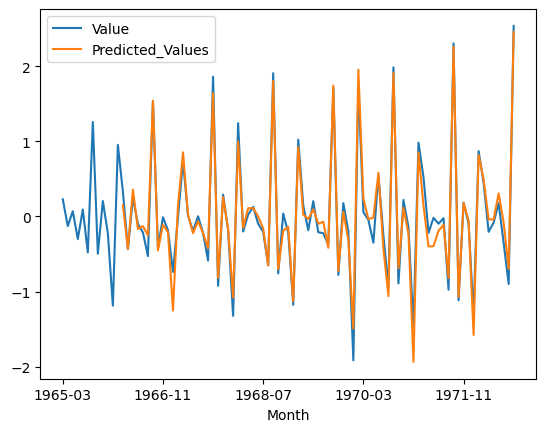

In [36]:
df2[['Value','Predicted_Values']].plot()
     

In [37]:
#PREDICTING THE VALUES

In [38]:
df2.Value += np.log(df).shift(1).Value
df2.Value += np.log(df).diff().shift(12).Value
df2.Predicted_Values += np.log(df).shift(1).Value 
df2.Predicted_Values += np.log(df).diff().shift(12).Value
df2.Value = np.exp(df2.Value)
df2.Predicted_Values = np.exp(df2.Predicted_Values)
     

In [39]:
df2

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Shifted_values_8,Shifted_values_9,Shifted_values_10,Shifted_values_11,Shifted_values_12,Predicted_Values
Month,,,,,,,,,,,,,,
1965-03,3208.488947,1.030642,-1.294844,-0.054899,-0.093795,0.108208,0.309526,0.254333,-0.315581,-0.049356,0.091867,-0.043008,0.082725,NaN
1965-04,2633.979472,0.228970,1.030642,-1.294844,-0.054899,-0.093795,0.108208,0.309526,0.254333,-0.315581,-0.049356,0.091867,-0.043008,NaN
1965-05,3794.075268,-0.127979,0.228970,1.030642,-1.294844,-0.054899,-0.093795,0.108208,0.309526,0.254333,-0.315581,-0.049356,0.091867,NaN
1965-06,2879.093320,0.070426,-0.127979,0.228970,1.030642,-1.294844,-0.054899,-0.093795,0.108208,0.309526,0.254333,-0.315581,-0.049356,NaN
1965-07,2660.720201,-0.301282,0.070426,-0.127979,0.228970,1.030642,-1.294844,-0.054899,-0.093795,0.108208,0.309526,0.254333,-0.315581,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972-05,4729.812478,-0.205091,0.448993,0.870689,-1.321185,-0.092717,0.184748,-1.117711,2.304334,-0.976279,-0.023189,-0.096514,-0.018096,4928.347400
1972-06,5358.041567,-0.081220,-0.205091,0.448993,0.870689,-1.321185,-0.092717,0.184748,-1.117711,2.304334,-0.976279,-0.023189,-0.096514,6107.709208
1972-07,3551.722682,0.176158,-0.081220,-0.205091,0.448993,0.870689,-1.321185,-0.092717,0.184748,-1.117711,2.304334,-0.976279,-0.023189,4659.700332


In [40]:
#PLOTTING THE VALUES AGAINST THE TEST DATA

<Axes: xlabel='Month'>

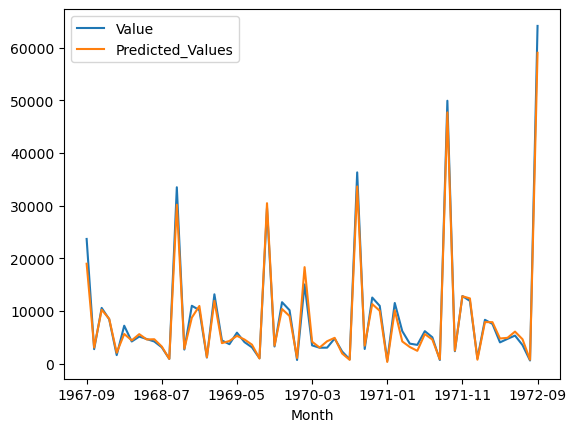

In [41]:
df2.iloc[30:,:][['Value','Predicted_Values']].plot()

In [42]:
vaf=df2.drop(['Shifted_values_1','Shifted_values_2','Shifted_values_3',
          'Shifted_values_4','Shifted_values_5','Shifted_values_6','Shifted_values_7','Shifted_values_8',
          'Shifted_values_9','Shifted_values_10','Shifted_values_11','Shifted_values_12','Predicted_Values'],axis=1)
vaf


,Value
Month,
1965-03,3208.488947
1965-04,2633.979472
1965-05,3794.075268
1965-06,2879.093320
1965-07,2660.720201
...,...
1972-05,4729.812478
1972-06,5358.041567
1972-07,3551.722682


In [43]:
bf=df2.drop(['Value','Shifted_values_1','Shifted_values_2','Shifted_values_3',
          'Shifted_values_4','Shifted_values_5','Shifted_values_6','Shifted_values_7','Shifted_values_8',
          'Shifted_values_9','Shifted_values_10','Shifted_values_11','Shifted_values_12'],axis=1)
bf

,Predicted_Values
Month,
1965-03,NaN
1965-04,NaN
1965-05,NaN
1965-06,NaN
1965-07,NaN
...,...
1972-05,4928.347400
1972-06,6107.709208
1972-07,4659.700332


In [44]:
pf2=bf['1971-01':]


In [45]:
pf2

,Predicted_Values
Month,
1971-01,357.273267
1971-02,10140.347436
1971-03,4240.387013
1971-04,3187.204355
1971-05,2463.883732
1971-06,5640.959052
1971-07,4606.433621
1971-08,840.777877
1971-09,47710.527358


In [46]:
ddf=bf[12:]
ddf

,Predicted_Values
Month,
1966-03,4272.588756
1966-04,2835.045615
1966-05,5818.073353
1966-06,2850.501201
1966-07,3286.218006
...,...
1972-05,4928.347400
1972-06,6107.709208
1972-07,4659.700332


In [47]:
pf1=ddf

In [48]:
af=vaf[12:]
af

,Value
Month,
1966-03,5132.560554
1966-04,2819.672437
1966-05,5228.796999
1966-06,3051.090288
1966-07,3018.554830
...,...
1972-05,4729.812478
1972-06,5358.041567
1972-07,3551.722682


In [49]:
#PLOTTING THE GRAPH BETWEEN ACTUAL VALUE AND PREDICTED VALUE

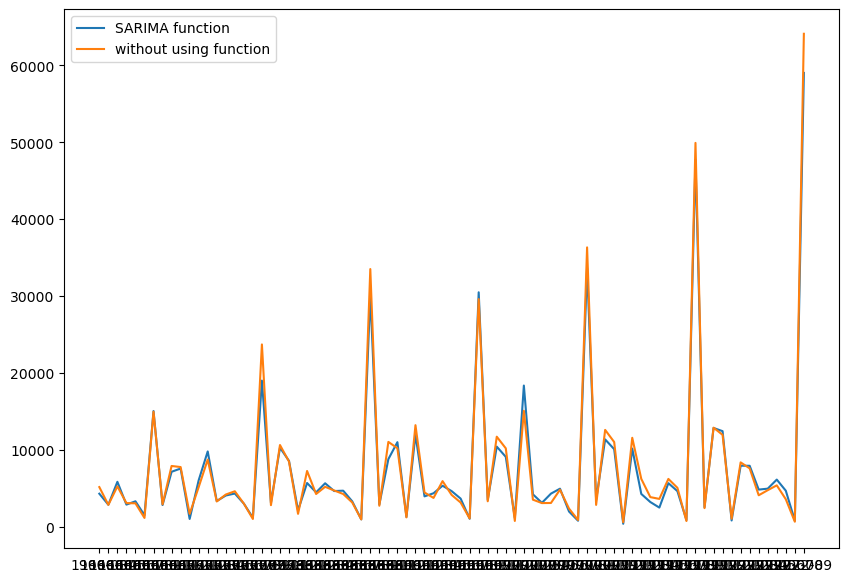

In [68]:

plt.figure(figsize=(10,7))
plt.plot(ddf,label='SARIMA function')
plt.plot(af,label='without using function')
plt.legend(loc='upper left')
plt.show()

In [51]:
#CALCULATING RMSE AND MAPE VALUES

In [52]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(af['Value'],ddf['Predicted_Values']))

print('RMSE:',rmse)

RMSE: 1222.9744690004304


In [53]:
from sklearn.metrics import mean_absolute_percentage_error

mape=mean_absolute_percentage_error(af['Value'],ddf['Predicted_Values'])

print('MAPE:',mape)

MAPE: 0.12453606073293946


In [54]:
#FITTING THE ARIMA MODEL ON THE DATASET USING AUTO ARIMA FUNCTION

In [55]:
#TRAIN AND TEST SPLIT

In [56]:

train_size = (int)(0.8 * df.shape[0])



In [57]:
train = pd.DataFrame(df[0:train_size])
test = pd.DataFrame(df[train_size:df.shape[0]])


In [58]:
test

,Value
Month,
1971-01,3934
1971-02,3162
1971-03,4286
1971-04,4676
1971-05,5010
1971-06,4874
1971-07,4633
1971-08,1659
1971-09,5951


In [59]:
#TRAIN AND TEST PLOT

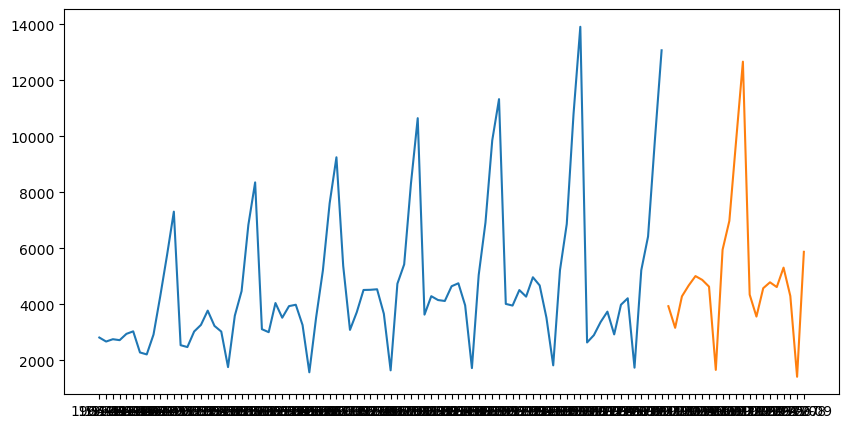

In [60]:
plt.figure(figsize=(10,5))
plt.plot(train)
plt.plot(test)

In [61]:
#USING AUTO ARIMA FUNCTION TO FIT THE MODEL

In [62]:
arima_model=auto_arima(train,start_p=0,d=1,start_q=0,
                      start_P=0,D=1,start_Q=0,
                      max_p=20,max_q=20,max_d=20,
                      max_P=20,max_Q=20,max_D=20,m=12,
                      seasonal=True,error_action='warn',
                      trace=True,supress_warnings=True,
                      stepwise=True,
                      random_state=20,n_fits=10)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1183.693, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1173.736, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1157.042, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1155.109, Time=0.05 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1157.009, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1158.348, Time=0.25 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1155.379, Time=0.06 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1155.138, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1173.612, Time=0.03 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1155.790, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 0.915 seconds


In [63]:
pf1=pd.DataFrame(arima_model.predict(n_periods=29),index=test.index)
pf1.columns=['predicted_pasengers']
pf1

,predicted_pasengers
Month,
1971-01,2260.640689
1971-02,2520.640689
1971-03,2991.640689
1971-04,3361.640689
1971-05,2548.640689
1971-06,3607.640689
1971-07,3838.640689
1971-08,1359.640689
1971-09,4842.640689


In [64]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -575.554
Date:                             Fri, 29 Sep 2023   AIC                           1155.109
Time:                                     14:28:38   BIC                           1159.634
Sample:                                 01-01-1964   HQIC                          1156.908
                                      - 12-01-1970                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8756      0.060    -14.663      0.000      -0.993      -0.759
sigma2       5.86e+05   7.15e+04      8.195      0.000    4.46e+05    7.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 6.95
Prob(Q):                              0.69   Prob(JB):                         0.03
Heteroskedasticity (H):               2.13   Skew:                             0.01
Prob(H) (two-sided):                  0.07   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""